In [3]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import tensorflow as tf
import keras
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import argparse
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn import tree

In [6]:
df = pd.read_hdf('./Datasets/CIC_IDS_2017/ids_2017.h5')
print(df.shape)


(2827876, 78)


In [7]:
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
#Here, specifying drop=True prevents .reset_index from creating a column containing the old index entries.
df = df.sample(frac=1, random_state =0xFFFF).reset_index(drop=True)
df = df[~df.duplicated()]
print(df.shape)

(2233164, 78)


In [8]:
df[' Label']

0            BENIGN
1            BENIGN
2            BENIGN
3            BENIGN
4            BENIGN
             ...   
2827871      BENIGN
2827872      BENIGN
2827873    DoS Hulk
2827874      BENIGN
2827875      BENIGN
Name:  Label, Length: 2233164, dtype: object

In [9]:
##select columns based on max std
# labels = df [' Label']
# selected_columns = np.asarray(df.std()).argsort()[::-1][0:12]
# df = df.iloc[:,selected_columns].join(labels)

In [10]:
# drop_columns = [
# #     'Unnamed: 0', 'Flow ID', ' Source IP', ' Source Port',
# #        ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp','SimillarHTTP',
# #         ' Inbound',
#                 ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
#        ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
#        ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
#        ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
#        ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
#        ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
#        ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
#        ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
#        'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count',
#        ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count',
#        ' CWE Flag Count', ' ECE Flag Count', ' Down/Up Ratio',
#        ' Average Packet Size', ' Avg Fwd Segment Size',
#        ' Avg Bwd Segment Size', ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk',
#        ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
#        ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets',
#        ' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
#        'Init_Win_bytes_forward', ' Init_Win_bytes_backward',
#        ' act_data_pkt_fwd', ' min_seg_size_forward', 'Flow Bytes/s']
# df = df.drop(columns= drop_columns)

In [11]:
def under_sample(df, n=5000, random_state=0xFFFF):
    tmp2 = pd.DataFrame(columns=df.columns)
    attacks, counts = np.unique(df[' Label'], return_counts=True)
    for each_attack in attacks:
        tmp = df[df[' Label'] == each_attack]
        if each_attack == 'BENIGN':
            n1= n*(len(attacks)-1)
            samples = tmp.sample(n =n1, random_state= random_state ,replace=True)
        else:
            samples = tmp.sample(n =n, random_state= random_state ,replace=True)
        
        tmp2 = tmp2.append(samples)
        
    return tmp2
    
    

In [12]:
def remove_attacks(df, attack_types =['DoS Hulk', 'Bot','SSH-Patator'] ):
    tmp =[]
    for each in attack_types:
        tmp.append(df[' Label'] != each)
    tmp = tuple(tmp)
    return np.logical_and.reduce(tmp)
        

In [6]:
def barplot_anomlaies(df1, attack_types =['DoS Hulk', 'Bot','SSH-Patator'], save=None):
    normal = np.asarray(df1[' Label']=='BENIGN').sum()
    known_anomalies = remove_attacks(df1, attack_types=attack_types).sum()
    unknown_anomalies = np.logical_not(remove_attacks(df1, attack_types=attack_types)).sum()
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    langs = ['Normal', 'Known_Attacks', 'Unknown_Attacks']
    students = [normal,known_anomalies,unknown_anomalies]
    ax.bar(langs,students, width =0.4, color =['c','m', 'm'])
    #plt.xticks(range(3), langs, rotation=30) 
    plt.title('Distribution of Traffic over Test dataset')
    plt.ylabel('Number of Samples')
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight' )
    plt.show()
    pass
    
    
    

In [13]:
attacks, counts = np.unique(df[' Label'], return_counts=True)

In [14]:
attacks

array(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
       'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed',
       'Infiltration', 'PortScan', 'SSH-Patator',
       'Web Attack � Brute Force', 'Web Attack � Sql Injection',
       'Web Attack � XSS'], dtype=object)

In [15]:
df = under_sample(df, n=5000)

In [16]:
#train test split
train_fraction = 0.75
np.random.seed(0xFFFF)
msk = np.random.rand(len(df)) < train_fraction
attack_types = ['DDoS', 'DoS GoldenEye', 'DoS Hulk', 'Web Attack � Brute Force', 'Infiltration']

train = df[msk]
##remove certain atack types from train dataset
train = train[remove_attacks(train, attack_types = attack_types)]
test = df[~msk]


#Train data
##train =
train_x = np.asarray( train.drop(columns = ' Label') )
test_x = np.asarray( test.drop(columns = ' Label') )

train_y = np.asarray(train[' Label']) != 'BENIGN'
test_y = np.asarray(test[' Label']) != 'BENIGN'

scaler = StandardScaler()
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

train_x_normal = train_x[~train_y]
train_y_normal = train_y[~train_y]

train_x_anomaly = train_x[train_y]



In [17]:
labels_condition =np.asarray(train_y).astype('int')
labels_condition[labels_condition==1] = 20

In [18]:
full_train_x = train_x

In [19]:
train_x, val_x, labels_condition, val_y = train_test_split(train_x, labels_condition, test_size=0.3, random_state=0xFFFF)

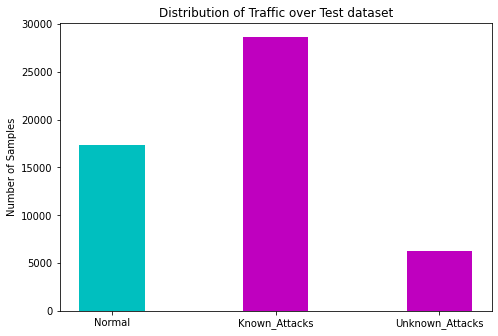

In [17]:
barplot_anomlaies(test, attack_types= attack_types)
#barplot_anomlaies(test, attack_types= attack_types, save ='./new/CICS_IDS/Traffic_distribution.png')

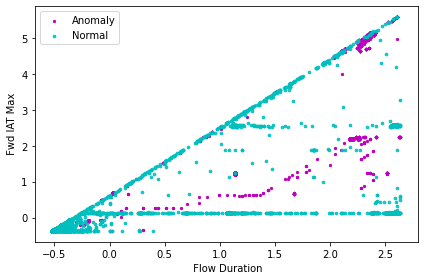

In [18]:
samples_for_scatter = 10000
xaxis = 0
yaxis = 22

plt.figure()
plt.scatter(train_x_anomaly[0:samples_for_scatter,xaxis] , train_x_anomaly[0:samples_for_scatter,yaxis] , c = 'm', label ='Anomaly', s=5)
plt.scatter(train_x_normal[0:samples_for_scatter,xaxis] , train_x_normal[0:samples_for_scatter,yaxis] , c = 'c', label ='Normal', alpha = 0.9, s=7)
plt.xlabel(df.columns[xaxis])
plt.ylabel(df.columns[yaxis])
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('./new/CICS_IDS/dataset_features.png', dpi=200)
plt.show()


# Decision Trees

In [19]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(full_train_x, train_y)
predicted = clf.predict(test_x)

In [20]:
f1_score(test_y,predicted)

0.8694393515391297

# SVM

In [14]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(full_train_x,train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [15]:
predicted = clf.predict(test_x)

In [16]:
f1_score(test_y,predicted)

0.8310306138804295

# Autoencoder

In [30]:
original_dim = train_x.shape[1]
input_shape = (original_dim, )
intermediate_dim = int(original_dim/2)
batch_size = 50
latent_dim = int(original_dim/4)
epochs = 500

In [31]:
inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(latent_dim, activation='relu')(x)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim)(x)
# instantiate encoder model
aae = Model(inputs, outputs, name='ae_mlp')

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

#vae.add_loss(vae_loss)
aae.compile(loss='mse', optimizer=optimizer)

In [32]:
callbacks = [
    tf.keras.callbacks.EarlyStopping( monitor='val_loss',min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True),
]
history = aae.fit(train_x_normal , train_x_normal, epochs=500, batch_size= batch_size , callbacks= callbacks,verbose =1, validation_split=0.2)

Train on 42104 samples, validate on 10527 samples
Epoch 1/500
42104/42104 [==============================] - 2s 42us/step - loss: 0.7399 - val_loss: 0.6363
Epoch 2/500
42104/42104 [==============================] - 2s 38us/step - loss: 0.5993 - val_loss: 0.5493
Epoch 3/500
42104/42104 [==============================] - 2s 37us/step - loss: 0.5187 - val_loss: 0.4960
Epoch 4/500
42104/42104 [==============================] - 2s 37us/step - loss: 0.4634 - val_loss: 0.4566
Epoch 5/500
42104/42104 [==============================] - 2s 36us/step - loss: 0.4218 - val_loss: 0.4313
Epoch 6/500
42104/42104 [==============================] - 1s 35us/step - loss: 0.3886 - val_loss: 0.4102
Epoch 7/500
42104/42104 [==============================] - 2s 36us/step - loss: 0.3606 - val_loss: 0.3959
Epoch 8/500
42104/42104 [==============================] - 2s 36us/step - loss: 0.3371 - val_loss: 0.3820
Epoch 9/500
42104/42104 [==============================] - 2s 36us/step - loss: 0.3151 - val_loss: 0.3

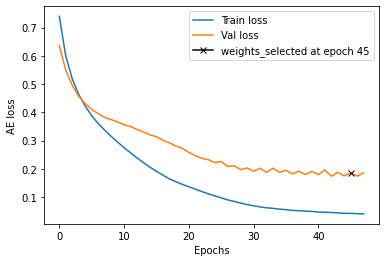

In [38]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label ='Train loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label ='Val loss')
plt.plot(len(history.history['val_loss'])-3,history.history['val_loss'][len(history.history['val_loss'])-3]  , marker='x', color='k', label='weights_selected at epoch {}'.format(len(history.history['val_loss'])-3))
plt.xlabel('Epochs')
plt.ylabel('AE loss')
#plt.savefig('./new/CICS_IDS/ae_loss.png', dpi=200)
plt.legend()

In [39]:
anomaly_detected_loss = np.mean((aae.predict(test_x)- test_x)**2, axis =-1)



In [40]:
threshold = np.quantile(anomaly_detected_loss, 0.99)
threshold

1.5896612109438315

In [ ]:
# plt.hist(anomaly_detected_loss, bins =200, range=(0,1), density =True)
# plt.vlines(threshold,0,60, linestyles='dashed')
# plt.text(threshold-0.2,63, 'Threshold')
# plt.xlabel('AE loss')
# plt.ylabel('Frequency')
# plt.savefig('./new/CICS_IDS/ae_loss_hist.png')

In [41]:
colors = test_y.astype('str')
colors[test_y] = 'm'
colors[~test_y] = 'c'

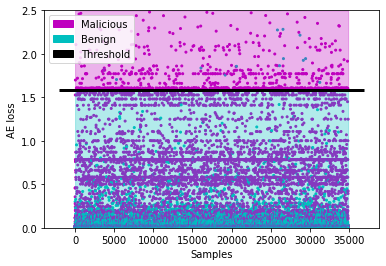

In [44]:
p = np.random.permutation(len(colors))
colors = colors[p]
anomaly_detected_loss = anomaly_detected_loss[p]


test_samples = len(test_x)
y_limit = (0,2.5)
alpha= 0.3

plt.scatter(range(test_samples), anomaly_detected_loss, c = colors, s = 4)
plt.hlines(threshold, -2000,test_samples+2000 ,'k', linewidths = 3, label= 'Threshold')

plt.fill_between(np.arange(test_samples), np.repeat(y_limit[0],test_samples), np.repeat(threshold, test_samples), color='c', alpha = alpha )
plt.fill_between(np.arange(test_samples), np.repeat(threshold,test_samples), np.repeat(y_limit[1], test_samples), color='m', alpha = alpha  )

plt.ylim(y_limit)
plt.ylabel('AE loss')
plt.xlabel('Samples')


red_patch = mpatches.Patch(color='m', label='Malicious')
blue_patch = mpatches.Patch(color='c', label='Benign')
threshold_ = mpatches.Patch(label = 'Threshold', color='k')

plt.legend(handles=[red_patch,blue_patch, threshold_])
#plt.savefig('./new/CICS_IDS/ae_partition.png', dpi=200)

In [45]:
anomaly_detected = anomaly_detected_loss > threshold
conf_matrix = confusion_matrix(test_y, anomaly_detected)
print(conf_matrix)
score =f1_score(test_y, anomaly_detected)
print('f1 score is ',score)
print('precision is ' , precision_score(test_y, anomaly_detected))
print('Recall is ', recall_score(test_y, anomaly_detected))

[[16558   811]
 [16641   901]]
f1 score is  0.0935909421418926
precision is  0.5262850467289719
Recall is  0.05136244441910843


# VAE

In [20]:
original_dim = train_x.shape[1]
input_shape = (original_dim, )
intermediate_dim = int(original_dim/2)
batch_size = 50
latent_dim = int(original_dim/4)
epochs = 500


In [21]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def train_loss(inputs,outputs):
    reconstruction_loss = K.mean(K.pow(inputs-outputs, 2), axis = -1)
    reconstruction_loss *= original_dim
    #tf.print(reconstruction_loss.shape)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    return vae_loss

def test_loss(inputss, outputss , mean, log_var):
    reconstruction_losses = np.mean((inputss-outputss)**2, axis = -1)
    reconstruction_losses *= original_dim
    kl_losses = 1 + log_var - np.square(mean) - np.exp(log_var)
    kl_losses = np.sum(kl_losses, axis = -1)
    kl_losses *= -0.5
    vae_losses = reconstruction_losses + kl_losses
    return vae_losses

def scheduler(epoch, learning_rate):
    if epoch < 20:
         return learning_rate
    else:
         return learning_rate * np.exp(-0.1)


In [22]:
# VAE model = encoder + decoder
# build encoder model

inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu' ,     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(inputs)
z_mean = Dense(latent_dim, name='z_mean',     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(x)
z_log_var = Dense(latent_dim, name='z_log_var',     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) , kernel_initializer='zeros', bias_initializer= 'zeros' )(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu',     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(latent_inputs)
outputs = Dense(original_dim ,    kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

#vae.add_loss(vae_loss)
vae.compile(optimizer=optimizer , loss=train_loss)


In [49]:
#train the model
callbacks = [
    tf.keras.callbacks.EarlyStopping( monitor='val_loss',min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True),
]
history = vae.fit(train_x_normal , train_x_normal, epochs=500, batch_size=  batch_size , callbacks= callbacks,verbose =1, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 42104 samples, validate on 10527 samples
Epoch 1/500
42104/42104 [==============================] - 2s 51us/step - loss: 72.8070 - val_loss: 63.9640
Epoch 2/500
42104/42104 [==============================] - 2s 43us/step - loss: 61.1857 - val_loss: 57.4467
Epoch 3/500
42104/42104 [==============================] - 2s 44us/step - loss: 55.7559 - val_loss: 54.2035
Epoch 4/500
42104/42104 [==============================] - 2s 42us/step - loss: 51.9132 - val_loss: 51.0525
Epoch 5/500
42104/42104 [==============================] - 2s 49us/step - loss: 48.2771 - val_loss: 48.1218
Epoch 6/500
42104/42104 [==============================] - 2s 49us/step - loss: 45.4318 - val_loss: 46.2009
Epoch 7/500
42104/42104 [==============================] - 2s 50us/step - loss: 43.3165 - val_loss: 44.7763
Epoch 8/500
42104/42104 [==============================] - 2s 50us/step - loss: 41.5180 - val_loss: 

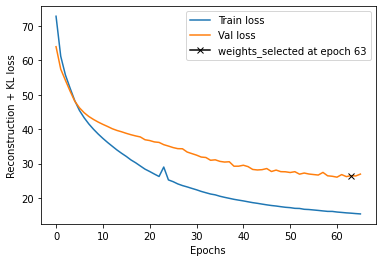

In [51]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label ='Train loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label ='Val loss')
plt.plot(len(history.history['val_loss'])-3,history.history['val_loss'][len(history.history['val_loss'])-3]  , marker='x', color='k', label='weights_selected at epoch {}'.format(len(history.history['val_loss'])-3))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction + KL loss')
plt.legend()
#plt.savefig('./new/CICS_IDS/vae_loss.png', dpi=200)

In [52]:
estimated_vae_output_normal = vae.predict(train_x_normal , batch_size= batch_size)
mean_latent_normal, std_latent_normal, _ = encoder.predict(train_x_normal, batch_size= batch_size)

normal_train_loss = test_loss(train_x_normal,estimated_vae_output_normal, mean_latent_normal, std_latent_normal) 

In [53]:
threshold = np.quantile(normal_train_loss, 0.99)
threshold

105.85126381264914

In [ ]:
# plt.hist(normal_train_loss, bins =200, range =(0,250), density =True)
# plt.vlines(threshold,0,0.1, linestyles='dashed')
# plt.text(threshold+0.005,0.1, 'Threshold')
# plt.xlabel('VAE loss')
# plt.ylabel('Frequency')
# plt.savefig('./new/CICS_IDS/vae_loss_hist.png')

In [54]:
estimated_vae_output = vae.predict(test_x , batch_size= batch_size)
mean_latent_test, std_latent_test, _ = encoder.predict(test_x, batch_size= batch_size)

anomaly_detected_loss = test_loss(test_x,estimated_vae_output, mean_latent_test, std_latent_test)

In [55]:
colors = test_y.astype('str')
colors[test_y] = 'm'
colors[~test_y] = 'c'

p = np.random.permutation(len(colors))
colors = colors[p]
anomaly_detected_loss = anomaly_detected_loss[p]

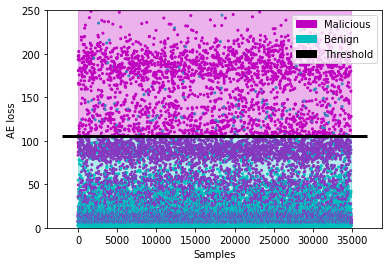

In [60]:
test_samples = len(test_x)
y_limit = (0,250)
alpha= 0.3

plt.scatter(range(test_samples), anomaly_detected_loss, c = colors, s = 4)
plt.hlines(threshold, -2000,test_samples+2000 ,'k', linewidths = 3, label= 'Threshold')

plt.fill_between(np.arange(test_samples), np.repeat(y_limit[0],test_samples), np.repeat(threshold, test_samples), color='c', alpha = alpha )
plt.fill_between(np.arange(test_samples), np.repeat(threshold,test_samples), np.repeat(y_limit[1], test_samples), color='m', alpha = alpha  )

plt.ylim(y_limit)
plt.ylabel('AE loss')
plt.xlabel('Samples')


red_patch = mpatches.Patch(color='m', label='Malicious')
blue_patch = mpatches.Patch(color='c', label='Benign')
threshold_ = mpatches.Patch(label = 'Threshold', color='k')

plt.legend(handles=[red_patch,blue_patch, threshold_], loc='upper right')
#plt.savefig('./new/CICS_IDS/vae_partition.png', dpi=200)

In [57]:
anomaly_detected = anomaly_detected_loss > threshold
conf_matrix = confusion_matrix(test_y, anomaly_detected)
print(conf_matrix)
score =f1_score(test_y, anomaly_detected)
print('f1 score is ',score)
print('precision is ' , precision_score(test_y, anomaly_detected))
print('Recall is ', recall_score(test_y, anomaly_detected))

[[15649  1720]
 [15729  1813]]
f1 score is  0.17205219454329776
precision is  0.5131616190206624
Recall is  0.10335195530726257


In [61]:
normal_data_mean,normal_data_std, normal = encoder.predict(train_x_normal, batch_size=batch_size)
anomaly_data_mean, anomlay_data_std, anomaly = encoder.predict(train_x_anomaly, batch_size=batch_size)

In [62]:
dimensions_to_plot = 3
ndm =np.mean(normal_data_mean, axis =0)
tmp = np.abs(ndm).argsort()
ndm = ndm[tmp][0:dimensions_to_plot]
adm = np.mean(anomaly_data_mean, axis =0)
tmp1 = np.abs(adm).argsort()[::-1]
adm = adm[tmp1][0:dimensions_to_plot]

nds =np.mean(np.exp(normal_data_std), axis =0)[tmp][0:dimensions_to_plot]
ads = np.mean(np.exp(anomlay_data_std), axis =0)[tmp1][0:dimensions_to_plot]

red_patch = mpatches.Patch(color='m', label='Malicious')
blue_patch = mpatches.Patch(color='c', label='Benign')

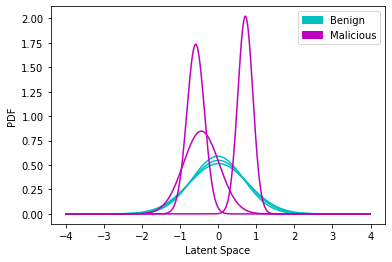

In [67]:
xs = np.arange(-4,4, 0.01)

plt.figure()

[plt.plot(xs,norm.pdf(xs,m,s), color='c') for m,s in zip(ndm, nds)]
[plt.plot(xs,norm.pdf(xs,m,s), color='m') for m,s in zip(adm, ads)]
#plt.ylim([0,1.5])
plt.xlabel('Latent Space')
plt.ylabel('PDF')

plt.legend(handles = [blue_patch, red_patch])
#plt.savefig('./new/CICS_IDS/vae_latent.png', dpi =200)

# EVAE

In [17]:
original_dim = train_x.shape[1]
input_shape = (original_dim, )
intermediate_dim = int(original_dim/2)
batch_size = 50
latent_dim = int(original_dim/4)
epochs = 500

In [18]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def train_loss(inputs,outputs):
#    labels1 = inputs1[1]
#     inputs =inputs1[0]
#     outputs = outputs1
    #labels1 =tf.reshape(labels1, (11,-1))
#     normal_labels = tf.where(tf.equal(labels,False))
#     anomaly_labels = tf.where(tf.equal(labels,True))
    
    
#     inputs =tf.keras.backend.reshape (tf.keras.backend.gather(inputs1[0], normal_labels).re(-1,original_dim)
#     outputs = tf.keras.backend.gather(outputs1, normal_labels).reshape(-1,original_dim)
                                      
                                      
    reconstruction_loss = K.mean(K.pow(inputs-outputs, 2), axis = -1)
    reconstruction_loss *= original_dim
    #tf.print(reconstruction_loss.shape)
    kl_loss = 1 + z_log_var - K.square(z_mean-labels) - K.exp(z_log_var)
    kl_loss = K.mean(kl_loss, axis=-1)
    kl_loss *= -0.5
    normal_vae_loss = K.mean(reconstruction_loss + kl_loss)
    
#     inputs = tf.keras.backend.gather(inputs1[0], anomaly_labels)
#     outputs = tf.keras.backend.gather(outputs1, anomaly_labels)
#     reconstruction_loss = K.mean(K.pow(inputs-outputs, 2), axis = -1)
#     reconstruction_loss *= original_dim
#     #tf.print(reconstruction_loss.shape)
#     kl_loss = 1 + z_log_var - K.square(z_mean-10) - K.exp(z_log_var)
#     kl_loss = K.sum(kl_loss, axis=-1)
#     kl_loss *= -0.5
#     anomaly_vae_loss = 0.5 *K.mean(reconstruction_loss + kl_loss)
    
    return normal_vae_loss

def test_loss(inputss, outputss , mean, log_var):
    reconstruction_losses = np.mean((inputss-outputss)**2, axis = -1)
    reconstruction_losses *= original_dim
    kl_losses = 1 + log_var - np.square(mean) - np.exp(log_var)
    kl_losses = np.sum(kl_losses, axis = -1)
    kl_losses *= -0.5
    vae_losses = reconstruction_losses+ kl_losses
    return vae_losses

def scheduler(epoch, learning_rate):
    if epoch < 20:
         return learning_rate
    else:
         return learning_rate * np.exp(-0.1)


In [19]:
# VAE model = encoder + decoder
# build encoder model

inputs = Input(shape=input_shape, name='encoder_input')

labels = Input(shape = (1,), name='label_input')
#labels = K.tile(labels, (batc,))

x = Dense(intermediate_dim, activation='relu' ,     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(inputs)
z_mean = Dense(latent_dim, name='z_mean',     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(x)
z_log_var = Dense(latent_dim, name='z_log_var',     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) , kernel_initializer='zeros', bias_initializer= 'zeros' )(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu',     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(latent_inputs)
outputs = Dense(original_dim ,    kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model([inputs, labels], outputs, name='vae_mlp')

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

#vae.add_loss(vae_loss)
vae.compile(optimizer=optimizer , loss=train_loss)


In [20]:
#train the model
callbacks = [
    tf.keras.callbacks.EarlyStopping( monitor='val_loss',min_delta= 0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True),
]
history = vae.fit([train_x,labels_condition] , train_x, epochs=500, batch_size= 50 , callbacks= callbacks,verbose =1, validation_data=([val_x,val_y], val_x), shuffle= True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60423 samples, validate on 25896 samples
Epoch 1/500
60423/60423 [==============================] - 5s 75us/step - loss: 138.7081 - val_loss: 125.5535
Epoch 2/500
60423/60423 [==============================] - 5s 75us/step - loss: 102.1735 - val_loss: 102.1461
Epoch 3/500
60423/60423 [==============================] - 5s 76us/step - loss: 79.0549 - val_loss: 80.0737
Epoch 4/500
60423/60423 [==============================] - 5s 76us/step - loss: 60.7129 - val_loss: 67.2662
Epoch 5/500
60423/60423 [==============================] - 5s 78us/step - loss: 50.8143 - val_loss: 60.9837
Epoch 6/500
60423/60423 [==============================] - 5s 76us/step - loss: 45.5655 - val_loss: 57.9057
Epoch 7/500
60423/60423 [==============================] - 4s 71us/step - loss: 42.0580 - val_loss: 55.6574
Epoch 8/500
60423/60423 [==============================] - 4s 69us/step - loss: 39.2710 - val_lo

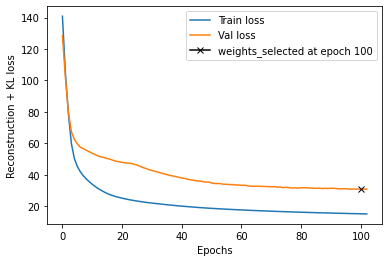

In [81]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label ='Train loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label ='Val loss')
plt.plot(len(history.history['val_loss'])-3,history.history['val_loss'][len(history.history['val_loss'])-3]  , marker='x', color='k', label='weights_selected at epoch {}'.format(len(history.history['val_loss'])-3))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction + KL loss')
plt.legend()
#plt.savefig('./new/CICS_IDS/evae_loss.png', dpi=200)

In [21]:
estimated_vae_output = vae.predict([val_x, np.zeros(len(val_x))] , batch_size= batch_size)
mean_latent_test, std_latent_test, _ = encoder.predict(val_x, batch_size= batch_size)

anomaly_detected_loss = test_loss(val_x,estimated_vae_output, mean_latent_test, std_latent_test)

In [22]:
xx = range(50,1800)
f1_scores=[]
for i in xx:
    anomaly_detected = anomaly_detected_loss > i
    f1_scores.append(f1_score(val_y.astype('bool'), anomaly_detected))

In [23]:
threshold = np.argmax(f1_scores)+xx[0]
threshold

735

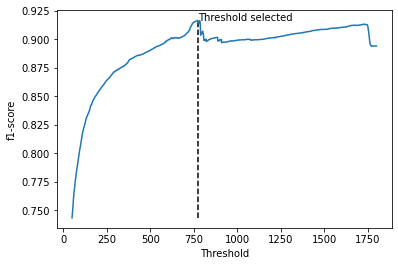

In [85]:
plt.plot(xx,f1_scores)
plt.xlabel('Threshold')
plt.ylabel('f1-score')
plt.text(threshold, np.max(f1_scores), 'Threshold selected')
plt.vlines(threshold,np.min(f1_scores),np.max(f1_scores), linestyles='dashed')
#plt.savefig('./new/CICS_IDS/evae_f1_scores.png', dpi=200)

In [24]:
estimated_vae_output = vae.predict([test_x, np.zeros(len(test_x))] , batch_size= batch_size)
mean_latent_test, std_latent_test, test_z = encoder.predict(test_x, batch_size= batch_size)

anomaly_detected_loss = test_loss(test_x,estimated_vae_output, mean_latent_test, std_latent_test)

In [87]:
threshold

772

In [88]:
anomaly_detected = anomaly_detected_loss > threshold

In [89]:
score =f1_score(test_y, anomaly_detected)

print('f1 score is ',score)
print('precision is ' , precision_score(test_y, anomaly_detected))
print('Recall is ', recall_score(test_y, anomaly_detected))
print(confusion_matrix(test_y, anomaly_detected))

f1 score is  0.8753119403423271
precision is  0.902415400447969
Recall is  0.8497890776422301
[[15757  1612]
 [ 2635 14907]]


In [28]:
colors = test_y.astype('str')
colors[test_y] = 'm'
colors[~test_y] = 'c'
# p = np.random.permutation(len(colors))
# colors = colors[p]
# anomaly_detected_loss = anomaly_detected_loss[p]

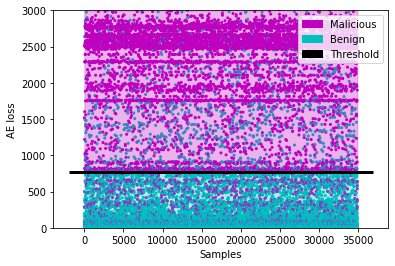

In [95]:
test_samples = len(test_x)
y_limit = (0,3000)
alpha= 0.3

plt.scatter(range(test_samples), anomaly_detected_loss, c = colors, s = 4)
plt.hlines(threshold, -2000,test_samples+2000 ,'k', linewidths = 3, label= 'Threshold')

plt.fill_between(np.arange(test_samples), np.repeat(y_limit[0],test_samples), np.repeat(threshold, test_samples), color='c', alpha = alpha )
plt.fill_between(np.arange(test_samples), np.repeat(threshold,test_samples), np.repeat(y_limit[1], test_samples), color='m', alpha = alpha  )

plt.ylim(y_limit)
plt.ylabel('AE loss')
plt.xlabel('Samples')


red_patch = mpatches.Patch(color='m', label='Malicious')
blue_patch = mpatches.Patch(color='c', label='Benign')
threshold_ = mpatches.Patch(label = 'Threshold', color='k')

plt.legend(handles=[red_patch,blue_patch, threshold_], loc='upper right')
#plt.savefig('./new/CICS_IDS/evae_partition.png', dpi=200)

In [26]:
normal_data_mean,normal_data_std, normal = encoder.predict(train_x_normal, batch_size=batch_size)
anomaly_data_mean, anomlay_data_std, anomaly = encoder.predict(train_x_anomaly, batch_size=batch_size)

In [27]:
dimensions_to_plot = 3
ndm =np.mean(normal_data_mean, axis =0)
tmp = np.abs(ndm).argsort()
ndm = ndm[tmp][0:dimensions_to_plot]
adm = np.mean(anomaly_data_mean, axis =0)
tmp1 = np.abs(adm).argsort()[::-1]
adm = adm[tmp1][0:dimensions_to_plot]

nds =np.mean(np.exp(normal_data_std), axis =0)[tmp][0:dimensions_to_plot]
ads = np.mean(np.exp(anomlay_data_std), axis =0)[tmp1][0:dimensions_to_plot]

red_patch = mpatches.Patch(color='m', label='Malicious')
blue_patch = mpatches.Patch(color='c', label='Benign')

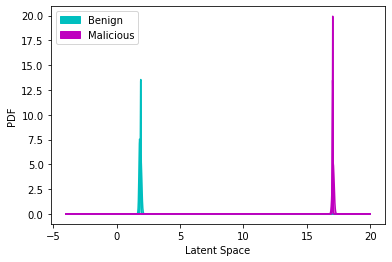

In [99]:
xs = np.arange(-4,20, 0.01)

plt.figure()

[plt.plot(xs,norm.pdf(xs,m,s), color='c') for m,s in zip(ndm, nds)]
[plt.plot(xs,norm.pdf(xs,m,s), color='m') for m,s in zip(adm, ads)]
#plt.ylim([0,1.5])
plt.xlabel('Latent Space')
plt.ylabel('PDF')

plt.legend(handles = [blue_patch, red_patch])
#plt.savefig('./new/CICS_IDS/evae_latent.png', dpi =200)

In [66]:
estimated_vae_output = vae.predict([test_x, np.zeros(len(test_x))] , batch_size= batch_size)
mean_latent_test, std_latent_test, test_z = encoder.predict(test_x, batch_size= batch_size)

anomaly_detected_loss = test_loss(test_x,estimated_vae_output, mean_latent_test, std_latent_test)

In [65]:
train_y.shape

(86319,)

In [63]:
train_x.shape

(60423, 77)

In [67]:
colors = test_y.astype('str')
colors[test_y] = 'm'
colors[~test_y] = 'c'

(-15.0, 45.0)

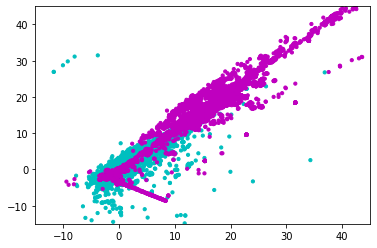

In [69]:
plt.scatter(test_z[:,9], test_z[:,18], s=10, c=colors)
plt.xlim(-15,45)
plt.ylim(-15,45)

In [1]:
abc =[1, 2,3]
print('ascac\n',abc)

ascac
 [1, 2, 3]
